<a href="https://colab.research.google.com/github/peremartra/cookbook/blob/main/notebooks/en/QLoRA_Tuning_PEFT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-Tuning a 7B model on a 16GB GPU with QLoRA.
_Authored by: [Pere Martra](https://github.com/peremartra)_
## Brief Introduction to Quantization
The main idea of quantization is simple: Reduce the precision of floating-point numbers, which normally occupy 32 bits, to integers of 8 or even 4 bits.

This reduction occurs in the model’s parameters, specifically in the weights of the neural layers, and in the activation values that flow through the model’s layers.

This means that we not only achieve an improvement in the model’s storage size and memory consumption but also greater agility in its calculations.

Naturally, there is a loss of precision, but particularly in the case of 8-bit quantization, this loss is minimal.



## Let's see a example of a quantized number.

In reality, what I want to examine is the precision loss that occurs when transitioning from a 32-bit number to a quantized 8/4-bit number and then returning to its original 32-bit value.

First, I'm going to create a function to quantize and another to unquantize.

In [ ]:
#Importing necesary linbraries
import numpy as np
import math
import matplotlib.pyplot as plt

In [ ]:
#Functions to quantize and unquantize
def quantize(value, bits=4):
    quantized_value = np.round(value * (2**(bits - 1) - 1))
    return int(quantized_value)

def unquantize(quantized_value, bits=4):
    value = quantized_value / (2**(bits - 1) - 1)
    return float(value)

Quatizied values:

In [ ]:
quant_4 = quantize(0.622, 4)
print (quant_4)
quant_8 = quantize(0.622, 8)
print(quant_8)

4
79


Unquantized values:

In [ ]:
unquant_4 = unquantize(quant_4, 4)
print(unquant_4)
unquant_8 = unquantize(quant_8, 8)
print(unquant_8)

0.5714285714285714
0.6220472440944882


If we consider that the original number was 0.622, it can be said that 8-bit quantization barely loses precision, and the loss from 4-bit quantization is manageable.

In [ ]:
x = np.linspace(-1, 1, 50)
y = [math.cos(val) for val in x]


y_quant_8bit = np.array([quantize(val, bits=8) for val in y])
y_unquant_8bit = np.array([unquantize(val, bits=8) for val in y_quant_8bit])

y_quant_4bit = np.array([quantize(val, bits=4) for val in y])
y_unquant_4bit = np.array([unquantize(val, bits=4) for val in y_quant_4bit])


Let’s plot a curve with the unquantized values of a cosine.


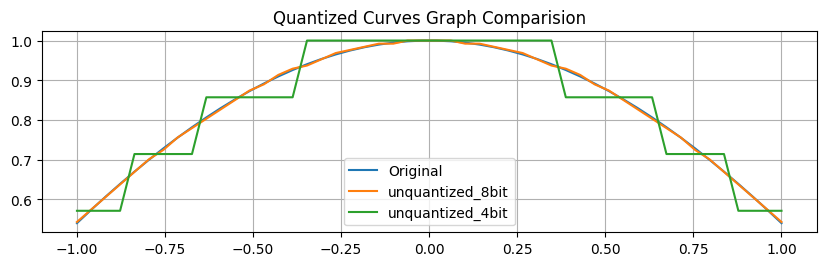

In [ ]:
plt.figure(figsize=(10, 12))

plt.subplot(4, 1, 1)
plt.plot(x, y, label="Original")
plt.plot(x, y_unquant_8bit, label="unquantized_8bit")
plt.plot(x, y_unquant_4bit, label="unquantized_4bit")
plt.legend()
plt.title("Quantized Curves Graph Comparision")
plt.grid(True)

As you can see, the difference between the 8-bit and the original values is minimal. However, we need to use 4-bit quantization if we want to load the 7B Model into a 16GB GPU without problems.


# QLoRA. Fine-tuning a 4-bit Quantized Model using LoRA.
We are going to fine-tune with LoRA a Bloom 7B Model Quantizated to 4 bits.

## Load the PEFT and Datasets Libraries.

The PEFT library contains the Hugging Face implementation of differente fine-tuning techniques, like LoRA Tuning.

Using the Datasets library we have acces to a huge amount of Datasets.

In [ ]:
!pip install -q accelerate==0.26.1
!pip install -q bitsandbytes==0.42.0
!pip install -q datasets==2.16.1
!pip install -q trl==0.7.0

I'm going to download the peft and Transformers libraries from their repositories on GitHub instead of using pip. This is not strictly necessary, but this way, you can get the newest versions of the libraries with support for newer models. If you want to check one of the latest models, you can use this trick.


In [ ]:
#Install the lastest versions of peft & transformers library recommended
#if you want to work with the most recent models
!pip install -q git+https://github.com/huggingface/peft.git
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


From the Transformers library, we import the necessary classes to load the model and the tokenizer.

Bloom is one of the smartest models available to be trained with the PEFT Library using LoRA Tuning. You can use any of the models in the Bloom Family. I encourage you to use at least two of them and observe the differences.


In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from trl import SFTTrainer
import torch

## Hugging Face login

## Load Model

In [ ]:
#Use any model you want, if you want to do some fast test, just use the smallest one.

#model_name = "bigscience/bloomz-560m"
#model_name="bigscience/bloom-1b1"
model_name = "bigscience/bloom-7b1"
target_modules = ["query_key_value"]

To load the model, we need a configuration class that specifies how we want the quantization to be performed. We’ll achieve this with the BitesAndBytesConfig from the Transformers library.

In [ ]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

We are specifying the use of 4-bit quantization and also enabling double quantization to reduce the precision loss.

For the bnb_4bit_quant_type parameter, I've used the recommended value in the paper [QLoRA: Efficient Finetuning of Quantized LLMs.](https://arxiv.org/abs/2305.14314)

Now, we can go ahead and load the model.

In [ ]:
device_map = {"": 0}
foundation_model = AutoModelForCausalLM.from_pretrained(model_name,
                    quantization_config=bnb_config,
                    device_map=device_map,
                    use_cache = False)



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/739 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/28.9k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.16G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Now we have the quantized version of the model in memory. Yo can try to load the unquantized version to see if it's possible.

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

tokenizer_config.json:   0%|          | 0.00/222 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/14.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

## Inference with the pre-trained model.
I'm going to do a test with the pre-trained model without fine-tuning, to see if something changes after the fine-tuning.

In [ ]:
#this function returns the outputs from the model received, and inputs.
def get_outputs(model, inputs, max_new_tokens=100):
    outputs = model.generate(
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        max_new_tokens=max_new_tokens,
        repetition_penalty=1.5, #Avoid repetition.
        early_stopping=False, #The model can stop before reach the max_length
        eos_token_id=tokenizer.eos_token_id,
    )
    return outputs

The dataset used for the fine-tuning contains prompts to be used with Large Language Models.

I'm going to request the pre-trained model that acts like a motivational coach.

In [ ]:
#Inference original model
input_sentences = tokenizer("I want you to act as a motivational coach. ", return_tensors="pt").to('cuda')
foundational_outputs_sentence = get_outputs(foundation_model, input_sentences, max_new_tokens=50)

print(tokenizer.batch_decode(foundational_outputs_sentence, skip_special_tokens=True))

["I want you to act as a motivational coach.  I don't mean that in the sense of telling people what they should do, but rather encouraging them and helping motivate their own actions.\nYou can start by asking questions like these:\n\nWhat are your goals?\nHow will this help achieve those?\n\nThen"]


The answer is good enough, Bloom 7B is a really well trained Model. But we will try to improve the quality with a sort fine-tuning process.


## Preparing the Dataset.
The Dataset useds is:

https://huggingface.co/datasets/fka/awesome-chatgpt-prompts

In [ ]:
from datasets import load_dataset
dataset = "fka/awesome-chatgpt-prompts"

#Create the Dataset to create prompts.
data = load_dataset(dataset)

data = data.map(lambda samples: tokenizer(samples["prompt"]), batched=True)
train_sample = data["train"].select(range(50))

del data
train_sample = train_sample.remove_columns('act')

display(train_sample)

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/153 [00:00<?, ? examples/s]

Dataset({
    features: ['prompt', 'input_ids', 'attention_mask'],
    num_rows: 50
})

In [ ]:
print(train_sample[:1])

{'prompt': ['I want you to act as a linux terminal. I will type commands and you will reply with what the terminal should show. I want you to only reply with the terminal output inside one unique code block, and nothing else. do not write explanations. do not type commands unless I instruct you to do so. when i need to tell you something in english, i will do so by putting text inside curly brackets {like this}. my first command is pwd'], 'input_ids': [[44, 4026, 1152, 427, 1769, 661, 267, 104105, 28434, 17, 473, 2152, 4105, 49123, 530, 1152, 2152, 57502, 1002, 3595, 368, 28434, 3403, 6460, 17, 473, 4026, 1152, 427, 3804, 57502, 1002, 368, 28434, 10014, 14652, 2592, 19826, 4400, 10973, 15, 530, 16915, 4384, 17, 727, 1130, 11602, 184637, 17, 727, 1130, 4105, 49123, 35262, 473, 32247, 1152, 427, 727, 1427, 17, 3262, 707, 3423, 427, 13485, 1152, 7747, 361, 170205, 15, 707, 2152, 727, 1427, 1331, 55385, 5484, 14652, 6291, 999, 117805, 731, 29726, 1119, 96, 17, 2670, 3968, 9361, 632, 269, 4

## Fine-Tuning.
The first step will be to create a LoRA configuration object where we will set the variables that specify the characteristics of the fine-tuning process.

In [ ]:
# TARGET_MODULES
# https://github.com/huggingface/peft/blob/39ef2546d5d9b8f5f8a7016ec10657887a867041/src/peft/utils/other.py#L220

import peft
from peft import LoraConfig, get_peft_model

lora_config = LoraConfig(
    r=16, #As bigger the R bigger the parameters to train.
    lora_alpha=16, # a scaling factor that adjusts the magnitude of the weight matrix. It seems that as higher more weight have the new training.
    target_modules=target_modules,
    lora_dropout=0.05, #Helps to avoid Overfitting.
    bias="none", # this specifies if the bias parameter should be trained.
    task_type="CAUSAL_LM"
)

The most important parameter is **r**, it defines how many parameters will be trained. As bigger the value more parameters are trained, but it means that the model will be able to learn more complicated relations between inputs and outputs.

Yo can find a list of the **target_modules** available on the [Hugging Face Documentation]( https://github.com/huggingface/peft/blob/39ef2546d5d9b8f5f8a7016ec10657887a867041/src/peft/utils/other.py#L220)

**lora_alpha**. Ad bigger the number more weight have the LoRA activations, it means that the fine-tuning process will have more impac as bigger is this value.

**lora_dropout** is like the commom dropout is used to avoid overfitting.

**bias** I was hesitating if use *none* or *lora_only*. For text classification the most common value is none, and for chat or question answering, *all* or *lora_only*.

**task_type**. Indicates the task the model is beign trained for. In this case, text generation.

In [ ]:
#Create a directory to contain the Model
import os
working_dir = './'

output_directory = os.path.join(working_dir, "peft_lab_outputs")

In the TrainingArgs we inform the number of epochs we want to train, the output directory and the learning_rate.

In [ ]:
#Creating the TrainingArgs
import transformers
from transformers import TrainingArguments # , Trainer
training_args = TrainingArguments(
    output_dir=output_directory,
    auto_find_batch_size=True, # Find a correct bvatch size that fits the size of Data.
    learning_rate= 2e-4, # Higher learning rate than full fine-tuning.
    num_train_epochs=5
)

Now we can train the model.
To train the model we need:


*   The Model.
*   The training_args
* The Dataset
* The result of DataCollator, the Dataset ready to be procesed in blocks.
* The LoRA config.





In [ ]:
tokenizer.pad_token = tokenizer.eos_token
trainer = SFTTrainer(
    model=foundation_model,
    args=training_args,
    train_dataset=train_sample,
    peft_config = lora_config,
    dataset_text_field="prompt",
    tokenizer=tokenizer,
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False)
)
trainer.train()

/usr/local/lib/python3.10/dist-packages/peft/utils/other.py:143: FutureWarning: prepare_model_for_int8_training is deprecated and will be removed in a future version. Use prepare_model_for_kbit_training instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:166: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(


Map:   0%|          | 0/50 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:207: UserWarning: You passed a tokenizer with `padding_side` not equal to `right` to the SFTTrainer. This might lead to some unexpected behaviour due to overflow issues when training a model in half-precision. You might consider adding `tokenizer.padding_side = 'right'` to your code.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss


TrainOutput(global_step=35, training_loss=2.3974227905273438, metrics={'train_runtime': 527.6123, 'train_samples_per_second': 0.474, 'train_steps_per_second': 0.066, 'total_flos': 1018165725954048.0, 'train_loss': 2.3974227905273438, 'epoch': 5.0})

In [ ]:
#Save the model.
peft_model_path = os.path.join(output_directory, f"lora_model")


In [ ]:
#Save the model.
trainer.model.save_pretrained(peft_model_path)

In [ ]:
#In case you are having memory problems uncomment this lines to free some memory
#import gc
#import torch
#del foundation_model
#del trainer
#del train_sample
#torch.cuda.empty_cache()
#gc.collect()

## Inference with the pretrained model

In [ ]:
#import peft
from peft import AutoPeftModelForCausalLM, PeftConfig
#import os

device_map = {"": 0}
working_dir = './'

output_directory = os.path.join(working_dir, "peft_lab_outputs")
peft_model_path = os.path.join(output_directory, f"lora_model")


In [ ]:
bnb_config2 = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

In [ ]:
#Load the Model.
loaded_model = AutoPeftModelForCausalLM.from_pretrained(
                                        peft_model_path,
                                        #torch_dtype=torch.bfloat16,
                                        is_trainable=False,
                                        #load_in_4bit=True,
                                        quantization_config=bnb_config2,
                                        device_map = 'cuda')

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

## Inference the fine-tuned model.

In [ ]:
input_sentences = tokenizer("I want you to act as a motivational coach. ", return_tensors="pt").to('cuda')
foundational_outputs_sentence = get_outputs(loaded_model, input_sentences, max_new_tokens=50)

print(tokenizer.batch_decode(foundational_outputs_sentence, skip_special_tokens=True))

['I want you to act as a motivational coach.  I will provide some information about my current situation, and then ask for your advice on how best to improve it. Your first response should be "I would suggest that..."  My next request could be: "So what do you recommend? How can this']


The result is really good. Let's compare the answer of the pre-trained model with the fine-tuned one:

* **Pretrained Model**: I want you to act as a motivational coach. I don't mean that in the sense of telling people what they should do, but rather encouraging them and helping motivate their own actions. You can start by asking questions like these: What are your goals? How will this help achieve those? Then.

* **Fine-Tuned Model**: I want you to act as a motivational coach. I will provide some details about an individual who needs help improving their confidence, and your goal is "Ideas for helping someone improve self-confidence." Your first suggestion should be "Provide encouragement when they need it most"; my reply.

As you can see, the result is really similar to the samples contained in the dataset used to fine-tune the model. And we only trained the model for some epochs and with a really small number of rows.

# Continue Learning
Please, play with all the variables in the notebook and drive your own experiments and get your conclusions. Changes in the ***lora_alpha*** can have a big effect in the results.

You can change the rest of **lora_config** values, maybe you can achieve a better result in less epochs, saving time and money in your projects.

